# Generate Scripts Using LSTM

# _______________________________________________________________

## 1.0 - Function Implementations

#### 1.1 - Import Dependencies

In [1]:
import numpy as np
import matplotlib as plt
import pandas as pd
import nltk
import tensorflow as tf
from tensorflow.contrib import seq2seq
from collections import Counter
import random
import csv
import seaborn as sns
%matplotlib inline

#### 1.2 - Data Preprocessing

In [2]:
puncs = {
            '--': '||long_dash||', 
             ',': '||comma||', 
             '.': '||period||',
             '(': '||left_paren||',
             ')': '||right_paren||',
             ';': '||semicolon||',
             '?': '||question||',
            '\n': '||new_line||',
             '"': '||double_quote||',
             '!': '||exclamation||'
}

In [3]:
def preprocess(input_text):
    """
    1. Convert all charatcers to lower case
    2. Assign unique tokens to punctuations
    :param input_text: Raw script text
    :return: Array of preprocessed words
    """
    
    new_text = input_text.lower()
    
    for token, replacement in puncs.items():
        new_text = new_text.replace(token, " " + replacement + " ")
        
    return new_text.split()

#### 1.3 - Create Lookup Table

In [4]:
def to_dicts(text):
    """
    Create dictionaries for index
    :param input_text: Array of preprocessed words
    :return int2word: Dictionary for index to word look up
    :return word2int: Dictionary for word to index look up
    """
    
    c = Counter(text)
    int2word, word2int = {}, {}
    
    for i, word in enumerate(c.items()):
        
        int2word[i] = word[0]
        word2int[word[0]] = i
        
    return int2word, word2int

#### 1.4 - Mini Batch Generator 

In [5]:
def get_batches(int_text, batch_size=119, seq_length=20):
    """
    Create dictionaries for index
    :param input_text: Array pf preprocessed words
    :return int2word: Dictionary for index to word look up
    :return word2int: Dictionary for word to index look up
    """

    int_text = int_text[16:]
    n_batches = (len(int_text)-1)//(batch_size * seq_length)    
    int_text = int_text[:n_batches * batch_size * seq_length + 1]
    int_text_sequences = \
            [int_text[i*seq_length:i*seq_length+seq_length] for i in range(0, n_batches * batch_size)]
        
    int_text = int_text[1:]
    int_text_targets = \
            [int_text[i*seq_length:i*seq_length+seq_length] for i in range(0, n_batches * batch_size)]
        
    output = []
    for batch in range(n_batches):
        inputs = []
        targets = []
        for size in range(batch_size):
            inputs.append(int_text_sequences[size * n_batches + batch])
            targets.append(int_text_targets[size * n_batches + batch])
        output.append([inputs, targets])
    return np.array(output)

#### 1.5 - LSTM Implementation

In [6]:
def LSTM(int2word, rnn_size=256, embed_dim=300):
    """
    Implementation of LSTM and its training
    :param int2word: Look up table for converting index to word
    :param rnn_size: Size of each lstm cell
    :param embed_dim: Size of the word embedding used before lstm
    :return: Network variables used for training and testing
    """
    
    # Create Input and Output Placeholders
    input_text = tf.placeholder(tf.int32, [None, None], name='input')
    targets = tf.placeholder(tf.int32, [None, None], name='targets')

    # Create LSTM Cell
    lstm = tf.contrib.rnn.BasicLSTMCell(rnn_size)
    cell = tf.contrib.rnn.MultiRNNCell([lstm, lstm])
    initial_state = cell.zero_state(tf.shape(input_text)[0], tf.float32)
    initial_state = tf.identity(initial_state, name= "initial_state")

    # Create Embedding
    inputs = tf.contrib.layers.embed_sequence(input_text, vocab_size=len(int2word), embed_dim=300)

    # Pass Data Through Network
    outputs, final_state = tf.nn.dynamic_rnn(cell, inputs, dtype=tf.float32)
    final_state = tf.identity(final_state, name="final_state")
    logits = tf.contrib.layers.fully_connected(outputs, len(int2word), activation_fn=None)
    probs = tf.nn.softmax(logits, name='probs')

    # Calculate Loss
    cost = seq2seq.sequence_loss(logits, targets, 
                                 tf.ones([tf.shape(input_text)[0], tf.shape(input_text)[1]]))

    # Optimize
    optimizer = tf.train.AdamOptimizer(0.01)
    gradients = optimizer.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
    train_op = optimizer.apply_gradients(capped_gradients)
    
    return input_text, targets, cost, initial_state, final_state, train_op, probs

#### 1.6 - Train Model

In [7]:
def train(sess, input_text, targets, initial_state, final_state, int_text, 
          batch_size=120, seq_length=20, num_epochs=100):
    """
    Perform network training
    :param sess: Session which contains the network
    :param batch_size: Size of each batch entering the network
    :param seq_length: Length of each sequence entering the network
    :param num_epochs: Number of iterations over the training set
    :return initial_state: Initial cell state after training network
    :return final_state: Final cell state after training the network
    """
    
    batches = get_batches(int_text, batch_size, seq_length)
    sess.run(tf.global_variables_initializer())
    losses = []

    print("Training ", end="")
    for epoch_i in range(num_epochs):
        state = sess.run(initial_state, {input_text: batches[0][0]})

        for batch_i, (x, y) in enumerate(batches):
            feed = {input_text:x, targets:y, initial_state:state}
            train_loss, state, _ = sess.run([cost, final_state, train_op], feed)
            
            # Log costs
            if (epoch_i * len(batches) + batch_i) % (show_every_n_batches) == 0:
                losses.append(train_loss)
    
            # Show every <show_every_n_batches> batches
            if (epoch_i * len(batches) + batch_i) % (show_every_n_batches*10) == 0:
                print(".", end="")
                #print('Epoch {:>3} Batch {:>4}/{}   train_loss = {:.3f}'.format(
                #    epoch_i, batch_i, len(batches), train_loss))

    # Save Model
    #saver = tf.train.Saver()
    #saver.save(sess, './save')
    #print('Model Trained and Saved')
    
    return initial_state, final_state, losses

#### 1.7 - Calculate Probable Word From Network Output

In [8]:
def pick_word(probabilities, int_to_vocab):
    """
    Pick the next word in the generated text
    :param probabilities: Probability distribution outputted by network
    :param int_to_vocab: Dictionary of word ids as the keys and words as the values
    :return: String of the predicted word
    """
    word_int = np.random.choice(len(int_to_vocab), p=probabilities)
    return int_to_vocab[word_int]

#### 1.8 - Test Model

In [9]:
def test(sess, input_text, initial_state, final_state, int2word, word2int, seq_length=20, gen_length=200, 
         start_char='moe_szyslak'):
    """
    Test network by generating text from start_char, and feeding output back into network
    :param sess: Session which contains the network
    :param seq_length: Length of each sequence entering the network
    :param gen_length: Number of words to be generated by the network
    :return gen_sentences: Array of words generated by the network
    """

    # Sentences generation setup
    gen_sentences = [start_char + ':']
    prev_state = sess.run(initial_state, {input_text: np.array([[1]])})

    # Generate sentences
    for n in range(gen_length):

        # Dynamic Input
        dyn_input = [[word2int[word] for word in gen_sentences[-seq_length:]]]
        dyn_seq_length = len(dyn_input[0])

        # Get Prediction
        probabilities, prev_state = sess.run(
            [probs, final_state],
            {input_text: dyn_input, initial_state: prev_state})

        pred_word = pick_word(probabilities[0][dyn_seq_length-1], int2word)
        gen_sentences.append(pred_word)
    return gen_sentences

#### 1.9 - Construct Sentences From Network Output

In [10]:
def print_sentences(gen_sentences):
    """
    Clean and process words generated by network and print them
    :param gen_sentences: Array of words generated by the network
    """
    script = " ".join(gen_sentences)

    for replacement, token in puncs.items():
        script = script.replace(token, replacement)

    script = script.replace(" .", ".")
    script = script.replace(" ,", ",")
    script = script.replace(" !", "!")
    script = script.replace(" ?", "?")
    script = script.replace("( ", "(")
    script = script.replace(" )", ")")
    script = script.replace(' \n', '\n')
    script = script.replace("  ", " ")
    script = script.replace(" i ", " I ")
    script = script.replace("i'm", "I'm")
    script = script.replace("i'll", "I'll")

    for i, line in enumerate(script.split("\n")):
        if i == 0:
            print(line)
        else:
            print(line[1:])

# _______________________________________________________

## 2.0 - Testing Model On Small Dataset

#### 2.1 - Load Small Dataset

In [11]:
f = open('./data/simpsons/moes_tavern_lines.txt')
text = f.read()
text = text[81:]

#### 2.2 - Display Sample Text From Small Dataset

In [12]:
print('\n'.join(text.split("\n")[:2]))

Moe_Szyslak: (INTO PHONE) Moe's Tavern. Where the elite meet to drink.
Bart_Simpson: Eh, yeah, hello, is Mike there? Last name, Rotch.


#### 2.3 - Smal Dataset Exploration

In [13]:
unique_words = len({word: None for word in text.split()})
scene_count = len(text.split("\n\n"))
line_count = len([line for scene in text.split("\n\n") for line in scene.split("\n")])
characters = Counter([line.split(":")[0] for line in text.split("\n")])

dat = [line_count, scene_count, unique_words, len(characters)]
labels = ("Number of lines", "Number of scenes", "Number of unique words", "Number of characters")

d = {}
for name, data in zip(labels, dat):
    d[name] = [data]
pd.DataFrame(data=d)

,Number of characters,Number of lines,Number of scenes,Number of unique words
0,282,4257,262,11492


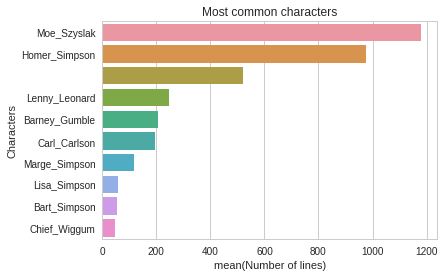

In [14]:
c = Counter(characters).most_common(10)
sns.set_style("whitegrid")
c1 = [i[0] for i in c]
c2 = [i[1] for i in c]
d = {'Characters': c1, 'Number of lines': c2}
df = pd.DataFrame(data=d)
ax = sns.barplot(x="Number of lines", y="Characters", data=df)
ax.set_title('Most common characters');

#### 2.4- Prepare Small Dataset

In [15]:
processed_text = preprocess(text)
int2word, word2int = to_dicts(processed_text)
int_text = [word2int[word] for word in processed_text]
show_every_n_batches = get_batches(int_text, batch_size=120, seq_length=20).shape[0]

#### 2.5 - Train Network On Small Dataset

Training ..........CPU times: user 1min 23s, sys: 7.14 s, total: 1min 30s
Wall time: 1min 6s


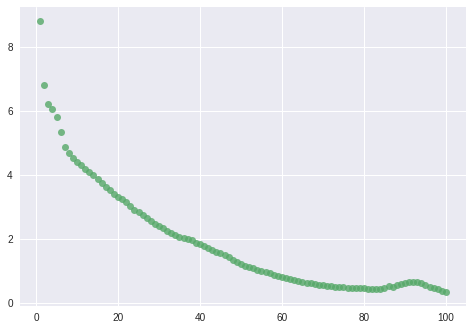

In [16]:
inp, out, cost, i_state, f_state, train_op, probs = LSTM(int2word, rnn_size=256, embed_dim=300)
sess = tf.Session()
%time i_state, f_state, losses = train(sess, inp, out, i_state, f_state, int_text, batch_size=120, \
                                       seq_length=20, num_epochs=100)
                                                                
sns.set(color_codes=True)
ax = sns.regplot(
    x=np.array([i for i in range(1,len(losses)+1)]), y=np.array(losses), color="g", fit_reg=False);

#### 2.6 - Test Network On Small Dataset

In [19]:
gen_sentences = test(sess, inp, i_state, f_state, int2word, word2int, \
                     seq_length=20, gen_length=200, start_char='moe_szyslak')
print_sentences(gen_sentences)

moe_szyslak: sorry, homer.


homer_simpson: (toasting) to play... moe?
c. _montgomery_burns: we're you come like is his ((camp around guys...
homer_simpson: wayne, it's true, but the little well, I think just in around, you little puke...
lenny_leonard: hey, what's business and a man, in which...


homer_simpson: yes. no one ever remembers. what do you go.
moe_szyslak: you want from, you get a few life could really her in springfield rounds.
moe_szyslak: what are you just waltz in with a woman to you exactly your bar ain't like... and I'm too all right, and I'll blow you.
moe_szyslak: and fausto! looks like you're really kind of every one at of the cash. my dad in the new moe-lennium.
moe_szyslak: and (reading) keep be another last.
homer_simpson: (sadly) yeah, you were sure, you can help.
chief_wiggum: you did. what's my hubub


# _______________________________________________________________

## 3.0 - Testing With A Larger Dataset

#### 3.1 - Load Large Dataset

In [16]:
large_data = []
characters = []
scene_count = 0
line_count = 0

with open('./data/simpsons.csv', newline='') as csvfile:
    data = csv.reader(csvfile, delimiter=',', quotechar='"')
    for i, row in enumerate(data):
        if row[5] == 'false':
            scene_count += 1
        else:
            line_count += 1
        if i > 0 and len(row) > 9 and row[5] != 'false':
            large_data.append(row[8].replace(" ", "_")+": "+row[10]+"\n")
            characters.append(row[8])

#### 3.2 - Large Dataset Exploration

In [17]:
large_processed_text = preprocess(" ".join(large_data))
dat = [line_count, scene_count, len(Counter(large_processed_text)), len(Counter(characters))]
labels = ("Number of lines", "Number of scenes", "Number of unique words", "Number of characters")

d = {}
for name, data in zip(labels, dat):
    d[name] = [data]
pd.DataFrame(data=d)

,Number of characters,Number of lines,Number of scenes,Number of unique words
0,6280,132114,26158,54307


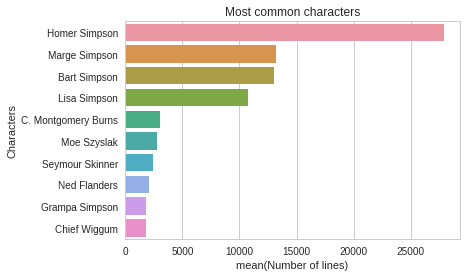

In [18]:
c = Counter(characters).most_common(10)
sns.set_style("whitegrid")
c1 = [i[0] for i in c]
c2 = [i[1] for i in c]
d = {'Characters': c1, 'Number of lines': c2}
df = pd.DataFrame(data=d)
ax = sns.barplot(x="Number of lines", y="Characters", data=df)
ax.set_title('Most common characters');

#### 3.3 - Prepare Large Dataset

In [19]:
large_int2word, large_word2int = to_dicts(large_processed_text)
large_int_text = [large_word2int[word] for word in large_processed_text]
show_every_n_batches = get_batches(large_int_text, batch_size=120, seq_length=20).shape[0]

#### 3.4 - Train Network On Large Dataset

Training .....CPU times: user 2h 12min 27s, sys: 45min 6s, total: 2h 57min 34s
Wall time: 2h 46min 40s


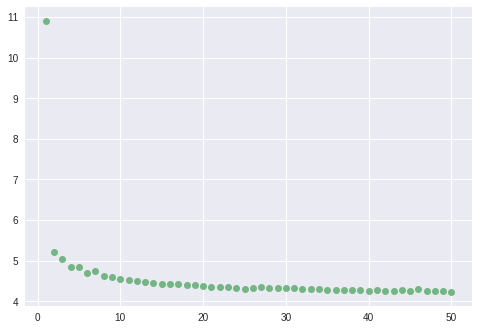

In [20]:
inp, out, cost, i_state, f_state, train_op, probs = LSTM(large_int2word, rnn_size=1024, embed_dim=1200)
sess = tf.Session()

%time i_state, f_state, losses = train(sess, inp, out, i_state, f_state, large_int_text, \
                                       batch_size=120, seq_length=20, num_epochs=50)

sns.set(color_codes=True)
ax = sns.regplot(x=np.array([i for i in range(1,len(losses)+1)]), y=np.array(losses), color="g", fit_reg=False);

#### 3.5 - Test Network On Large Dataset

In [21]:
gen_sentences = test(sess, inp, i_state, f_state, large_int2word, large_word2int, 
                     seq_length=20, gen_length=200, start_char='moe_szyslak')

print_sentences(gen_sentences)

moe_szyslak:, for starters, they're having it so smooth would be twenty-first out of the coward.
bart_simpson: mom! bart's jive are not gonna wave your job you do weather.
homer_simpson: what?!!
joe_laboot: sure I'm stayin' here.
marge_simpson: could you believe?
homer_simpson: all right, son.
lisa_simpson: I made him right.
kid_demon: wow, we owe you gray! quit, tightenin' the whales, --
lisa_simpson: okay, ninja fight!
homer_simpson: gig, nyuk, nyung roberts! do not drop to the city fighters! nobody blows taken, right?
homer_simpson: it's joan application... and hurled the tv gel.
wilbur: yeah. wait, what's an upgrade.
marge_simpson: I still sing yourself for these for a digital attitudes...
pleasant_female_voice: I mean I seek.
homer_simpson: oh, because they're not. he was right after this to what's different from earth?
homer_simpson: and in the one good night.
bernice_hibbert: well, they do your hopes this kids! we can he
